<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Settings" data-toc-modified-id="Settings-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Settings</a></span></li><li><span><a href="#Function" data-toc-modified-id="Function-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Function</a></span><ul class="toc-item"><li><span><a href="#Calculate-Shannon-Entropy" data-toc-modified-id="Calculate-Shannon-Entropy-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Calculate Shannon Entropy</a></span></li><li><span><a href="#Split-Dataset" data-toc-modified-id="Split-Dataset-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Split Dataset</a></span></li><li><span><a href="#Choose-The-Best-Feature-To-Split" data-toc-modified-id="Choose-The-Best-Feature-To-Split-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Choose The Best Feature To Split</a></span></li><li><span><a href="#Create-Decision-Tree-(ID3)" data-toc-modified-id="Create-Decision-Tree-(ID3)-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Create Decision Tree (ID3)</a></span></li><li><span><a href="#Visualise-Dicision-Tree" data-toc-modified-id="Visualise-Dicision-Tree-2.5"><span class="toc-item-num">2.5&nbsp;&nbsp;</span>Visualise Dicision Tree</a></span></li></ul></li><li><span><a href="#Test-&amp;-Save" data-toc-modified-id="Test-&amp;-Save-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Test &amp; Save</a></span></li><li><span><a href="#Practice" data-toc-modified-id="Practice-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Practice</a></span></li></ul></div>

In [19]:
import sys
import os
import time
import datetime
import pickle
import json
import re
import operator
from collections import defaultdict

import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [20]:
import matplotlib.pyplot as plt
# %matplotlib inline

from math import log

In [21]:
sys.path.append("/Users/xuzhu/Desktop/code/assistants") # my package

from toolbox.os_assistant import scan_folder

---

## Settings

In [22]:
DATA_FOLDER = "/Users/xuzhu/Desktop/data/open_dataset"

## Function

Given a discrete random variable $X$, with possible outcomes $x_{1},..., x_{n}$, which occur with probability $P(x_{n}),..., P(x_{n})$, the **<font color=red>entropy</font>** of $X$ is formally defined as:<br>
$$H = - \sum^{n}_{i=1} p(x_{i}) log_{2} p(x_{i})$$

In [23]:
feature_name_list = ["is_big", "is_white"]
dataset = [
    [1, 1, "Y"],
    [1, 0, "N"],
    [1, 1, "Y"],
    [0, 1, "N"],
    [0, 1, "N"]
]

### Calculate Shannon Entropy

In [24]:
# Calculate Shannon Entropy

def calculate_shannon_entropy(dataset):
    """
    dataset = [
        [1, 1, "Y"],
        [1, 0, "N"],
        [1, 1, "Y"],
        [0, 1, "N"],
        [0, 1, "N"]
    ]
    """
    entity_num = len(dataset) # data_set -- list_like
    label_stats = {}
    for entity_vector in dataset:
        current_class = entity_vector[-1] # entity_vector -- list_like [d1, d2, ..., dn], assume db is the class
        if current_class not in label_stats.keys():
            label_stats[current_class] = 0
        else:
            pass
        label_stats[current_class] += 1

    shannon_entropy = 0
    for key in label_stats.keys(): # slightly slower than 'for key in label_stats:'
        label_prob = label_stats[key] / entity_num
        shannon_entropy = shannon_entropy - label_prob * log(label_prob, 2)
    
    return shannon_entropy


calculate_shannon_entropy(dataset)

0.9709505944546686

### Split Dataset

In [25]:
def split_dataset(
    dataset,
    axis,
    value
):
    new_dataset=[]
    for entity_vector in dataset:
        if entity_vector[axis] == value: # entity_vector: [d1, d2, d3]
            reduced_entity_vector = entity_vector[:axis]
            reduced_entity_vector.extend(entity_vector[axis+1:]) # reduced_entity_vector: [d1, d3]
                # drop entity_vector[axis] and keep the original list unchanged
            new_dataset.append(reduced_entity_vector)
        else:
            pass
            
    return new_dataset


split_dataset(dataset, 2, "Y")
split_dataset(dataset, 2, "N")

[[1, 1], [1, 1]]

[[1, 0], [0, 1], [0, 1]]

### Choose The Best Feature To Split

In [26]:
def choose_feature_to_split(dataset):
    feature_cnt = len(dataset[0]) - 1
    base_entropy = calculate_shannon_entropy(dataset)
    best_info_gain = 0
    best_feature_axis = -1 # create a default best feature
                           # -1 means no best feature and choose the last one as the best feature
    
    for i in range(feature_cnt):
        feature_list = [entity_temp[i] for entity_temp in dataset]
        uniq_feature_set = set(feature_list)
        
        new_entropy = 0
        for feature_value in uniq_feature_set:
            sub_dataset = split_dataset(
                dataset=dataset,
                axis=i,
                value=feature_value
            )
            prob = len(sub_dataset) / len(dataset)
            new_entropy += prob * calculate_shannon_entropy(sub_dataset) # weighted
            
        info_gain = base_entropy - new_entropy # old - new
        if info_gain > best_info_gain:
            best_info_gain = info_gain
            best_feature_axis = i
        else:
            pass
    
    return best_feature_axis   


choose_feature_to_split(dataset)

0

### Create Decision Tree (ID3)

In [27]:
def majority_vote(class_list):
    class_stats = {}
    for class_value in class_list:
        if class_value not in class_stats.keys():
            class_stats[class_value] = 0
        else:
            pass
        class_stats[class_value] += 1
    
    sorted_class_stats = sorted(
        class_stats.items(),
        key=operator.itemgetter(1),
        reverse=True
    )
    
    voted_class_value = sorted_class_stats[0][0]
    return voted_class_value

In [28]:
def create_decision_tree__id3(
    dataset,
    feature_name_list
):
    class_list = [entity_temp[-1] for entity_temp in dataset]
    
    if class_list.count(class_list[0]) == len(class_list): # leaf node -- stop condition 1
        return class_list[0]
    if len(dataset[0]) == 1: # traversed all features -- stop condition 2
        return majority_vote(class_list)
    
    feature_axis = choose_feature_to_split(dataset)
    feature_name = feature_name_list[feature_axis]
    tree = {
        feature_name: {}
    }
    del feature_name_list[feature_axis]
    
    feature_value_list = [entity_temp[feature_axis] for entity_temp in dataset]
    uniq_feature_set = set(feature_value_list)
    for feature_value in uniq_feature_set:
        sub_feature_name_list = feature_name_list[:]
        tree[feature_name][feature_value] = create_decision_tree__id3(
            dataset = split_dataset(
                dataset,
                axis=feature_axis,
                value=feature_value
            ),
            feature_name_list = sub_feature_name_list
        )
    
    return tree


decision_tree__id3 = create_decision_tree__id3(dataset, feature_name_list)
decision_tree__id3

{'is_big': {0: 'N', 1: {'is_white': {0: 'N', 1: 'Y'}}}}

### Visualise Dicision Tree

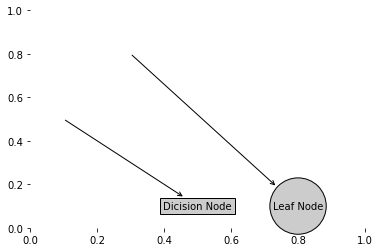

In [29]:
decision_node_args = {
    "boxstyle": "square", # "sawtooth",
    "fc": "0.8"
}
leaf_node_args = {
    "boxstyle": "circle", # "round",
    "fc": "0.8"
}
# https://matplotlib.org/stable/tutorials/text/annotations.html
arrow_args = {"arrowstyle": "<-"} # reversed arrow !!!


def plot_node(
    node_text,
    node_type,
    point_position,
    text_position
):
    create_plot.ax1.annotate(
        node_text,
        xy=point_position,          # The point (x, y) to annotate
        xycoords="axes fraction",
        xytext=text_position,       # The position (x, y) to place the text at
        textcoords="axes fraction",
        va="center",
        ha="center",
        bbox=node_type,
        arrowprops=arrow_args 
            # The properties used to draw a FancyArrowPatch arrow between the positions xy and xytext
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html
    )
    

def create_plot():
    fig = plt.figure(num=1, facecolor="white") # background color = white
    fig.clf() # clear
    create_plot.ax1 = plt.subplot(111, frameon=False)
    plot_node(
        node_text="Dicision Node",
        node_type=decision_node_args,
        point_position=(0.1, 0.5),
        text_position=(0.5, 0.1)
    )
    plot_node(
        node_text="Leaf Node",
        node_type=leaf_node_args,
        point_position=(0.3, 0.8),
        text_position=(0.8, 0.1)
    )
    plt.show()

    
create_plot()

In [30]:
"""
{
    "is_big": {
        0: "N",
        1: {
            "is_white": {
                0: "N",
                1: "Y"
            }
        }
    }
}
"""
# tree_dict = {'is_big': {0: 'N', 1: {'is_white': {0: 'N', 1: 'Y'}}}}

def get_leaf_qty(tree_dict):
    leaf_qty = 0
    first_key = list(tree_dict.keys())[0]
    sub_tree_dict = tree_dict[first_key]
    for key in sub_tree_dict.keys():
        if type(sub_tree_dict[key]).__name__ == "dict": # if type(sub_tree_dict[key]) is dict
            leaf_qty = leaf_qty + get_leaf_qty(sub_tree_dict[key])
        else:
            leaf_qty += 1
            
    return leaf_qty

print(get_leaf_qty(decision_tree__id3))


def get_tree_depth(tree_dict):
    max_depth = 0
    first_key = list(tree_dict.keys())[0]
    sub_tree_dict = tree_dict[first_key]
    for key in sub_tree_dict.keys():
        if type(sub_tree_dict[key]) is dict:
            this_depth = 1 + get_tree_depth(sub_tree_dict[key])
        else:
            this_depth = 1
            
        if this_depth > max_depth:
            max_depth = this_depth
    
    return max_depth

print(get_tree_depth(decision_tree__id3))

'\n{\n    "is_big": {\n        0: "N",\n        1: {\n            "is_white": {\n                0: "N",\n                1: "Y"\n            }\n        }\n    }\n}\n'

3
2


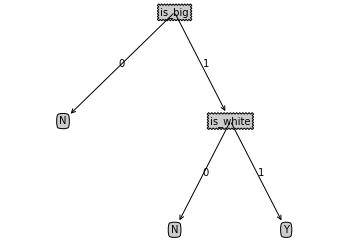

In [31]:
decision_node_args = {
    "boxstyle": "sawtooth", # "sawtooth",
    "fc": "0.8"
}
leaf_node_args = {
    "boxstyle": "round4", # "round",
    "fc": "0.8"
}
arrow_args = {"arrowstyle": "<-"} # reversed arrow !!!


def plot_node(
    node_text,
    node_type,
    point_position,
    text_position
):
    create_plot.ax1.annotate(
        node_text,
        xy=point_position,          # The point (x, y) to annotate
        xycoords="axes fraction",
        xytext=text_position,       # The position (x, y) to place the text at
        textcoords="axes fraction",
        va="center",
        ha="center",
        bbox=node_type,
        arrowprops=arrow_args 
            # The properties used to draw a FancyArrowPatch arrow between the positions xy and xytext
            # https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.annotate.html
    )
    
    
def plot_mid_text(
    parent_point,
    child_point,
    text
):
    x_mid = (parent_point[0] - child_point[0])/2 + child_point[0]
    y_mid = (parent_point[1] - child_point[1])/2 + child_point[1]
    create_plot.ax1.text(x_mid, y_mid, text)

    
def plot_tree(
    tree,
    parent_point,
    node_text
):
    leaf_qty = get_leaf_qty(tree)
    tree_depth = get_tree_depth(tree)
    first_key = list(tree.keys())[0]
    child_point = (plot_tree.x_off + (1 + leaf_qty) / 2 / plot_tree.total_width, plot_tree.y_off)
    plot_mid_text(
        parent_point=parent_point,
        child_point=child_point,
        text=node_text
    )
    plot_node(
        node_text=first_key,
        node_type=decision_node_args,
        point_position=parent_point,
        text_position=child_point
    )
    
    sub_tree = tree[first_key]
    plot_tree.y_off = plot_tree.y_off - 1 / plot_tree.total_depth
    for key in sub_tree.keys():
        if type(sub_tree[key]) is dict:
            plot_tree(
                tree=sub_tree[key],
                parent_point=child_point,
                node_text=str(key)
            )
        else:
            plot_tree.x_off = plot_tree.x_off + 1 / plot_tree.total_width
            plot_node(
                node_text=sub_tree[key],
                node_type=leaf_node_args,
                point_position=child_point,
                text_position=(plot_tree.x_off, plot_tree.y_off)
            )
            plot_mid_text(
                parent_point=child_point,
                child_point=(plot_tree.x_off, plot_tree.y_off),
                text=str(key)
            )
            
    plot_tree.y_off = plot_tree.y_off + 1 / plot_tree.total_depth

    
def create_plot(tree):
    fig = plt.figure(num=1, facecolor="white") # background color = white
    fig.clf() # clear
    # axprops = dict(xticks=[], yticks=[])
    # create_plot.ax1 = plt.subplot(111, frameon=False, **axprops)
    create_plot.ax1 = plt.subplot(111, frameon=False, xticks=[], yticks=[])
    
    plot_tree.total_width = float(get_leaf_qty(tree))
    plot_tree.total_depth = float(get_tree_depth(tree))
    plot_tree.x_off = -0.5 / plot_tree.total_width # default 0-1
    plot_tree.y_off = 1 # default 0-1
    plot_tree(
        tree=tree, 
        parent_point=(0.5, 1.0),
        node_text=""
    )
    
    plt.show()

    
create_plot(decision_tree__id3)

## Test & Save

In [32]:
def tree_test(
    input_tree,
    feature_names,
    test_vector
):
    first_key = list(input_tree.keys())[0]
    sub_tree = input_tree[first_key]
    feature_index = feature_names.index(first_key)
    for key in sub_tree.keys():
        if key == test_vector[feature_index]:
            if type(sub_tree[key]) is dict:
                output_label = tree_test(
                    input_tree=sub_tree[key],
                    feature_names=feature_names,
                    test_vector=test_vector
                )
            else:
                output_label = sub_tree[key]
        else:
            pass
    
    return output_label


dataset = [
    [1, 1, "Y"],
    [1, 0, "N"],
    [1, 1, "Y"],
    [0, 1, "N"],
    [0, 1, "N"]
]
feature_name_list = ["is_big", "is_white"]
tree_dict = {'is_big': {0: 'N', 1: {'is_white': {0: 'N', 1: 'Y'}}}}
test_vector_1 = [1, 0]
test_vector_2 = [1, 1]

tree_test(
    input_tree=decision_tree__id3,
    feature_names=feature_name_list,
    test_vector=test_vector_1
)

tree_test(
    input_tree=decision_tree__id3,
    feature_names=feature_name_list,
    test_vector=test_vector_2
)

'N'

'Y'

In [35]:
def store_tree(
    input_tree,
    filepath
):
    with open(filepath, "wb") as f_write:
        pickle.dump(input_tree, f_write)
        
#     f_write = open(filepath, "w")
#     pickle.dump(input_tree, f_write)
#     f_write.close()


def grab_tree(filepath):
    with open(filepath, "rb") as fr:
        f_read = pickle.load(fr)
    
    return f_read

savepath = os.path.join(DATA_FOLDER, "temp__saved_decision_tree.txt")
store_tree(input_tree=decision_tree__id3, filepath=savepath)

original_tree = grab_tree(filepath=savepath)
original_tree

{'is_big': {0: 'N', 1: {'is_white': {0: 'N', 1: 'Y'}}}}

## Practice